### 北京-海淀-万柳 房屋数据抓取思路

抓取二手房和租房信息：

- 二手房网站：https://esf.fang.com/  
- 租房网站：https://zu.fang.com/  

观察网页结构后可知：

- 二手房 URL 格式：`https://esf.fang.com/*****/**-i3{num}`，可遍历获取所有房源信息  
- 租房 URL 格式：`https://zu.fang.com/*****/**-i3{num}`，可遍历获取所有房源信息  

相比使用 Selenium 模拟浏览器操作，可使用 `requests` 直接抓取数据。


In [13]:
# 导入必要的库
import re
import requests
import pandas as pd
from lxml import etree
from tqdm.notebook import tqdm

In [14]:
# 以下是网站中房子元素中具体所需字段的具体Xpath结构,便于之后解析
# 二手房网站
URL1 = "https://esf.fang.com/" 
data_xpath1 = '//*[@class="shop_list shop_list_4"]/dl' # 二手房列表 xpath
house_xpath_map1 = {
    # 标题、面积、价格
    "title": ".//h4/a/@title",
    "area_sqm": ".//p[@class='tel_shop']/text()[2]",   
    "total_price": ".//dd[@class='price_right']/span[@class='red']/b/text()",
    "unit_price": ".//dd[@class='price_right']/span[last()]/text()",  # 元/㎡
}

# 租房网站
URL2 = "https://zu.fang.com/"
data_xpath2 = '//*[@class="houseList"]/dl' # 租房列表 xpath
rent_xpath_map = {
    # 标题、面积、价格
    "title": ".//p[@class='title']/a/@title",
    "area_sqm": ".//p[contains(@class,'font15')]/text()[3]", 
    "price": ".//div[@class='moreInfo']//span[@class='price']/text()",  # 元/月
}

In [15]:
def expand_urls(base_url: str):
    match = re.search(r'-i3(\d+)/', base_url)
    if not match:
        raise ValueError("URL 中未找到 '-i{num}/' 结构")
    max_page = int(match.group(1))
    prefix = re.sub(r'-i3\d+/', '', base_url)
    urls = [f"{prefix}-i3{i}/" for i in range(1, max_page + 1)]
    return urls

def get_doc(url):
    resp = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}, timeout=10)
    resp.encoding = 'utf-8'
    return etree.HTML(resp.text)

def get_data(dl, xpath_map):
    data = {}
    for field, xpath in xpath_map.items():
        elements = dl.xpath(xpath)
        if not elements:
            data[field] = None
        elif len(elements) == 1:
            data[field] = elements[0].strip()
        else:
            data[field] = [el.strip() for el in elements]
    return data

def fetch_second_hand_houses(url):
    house_data = []
    urls = expand_urls(end_url1)
    for url in tqdm(urls, desc="抓取二手房数据", ncols=100):
        doc = get_doc(url)
        dl_elements = doc.xpath(data_xpath1)
        for dl in dl_elements:
            dl_data = get_data(dl, house_xpath_map1)
            house_data.append(dl_data)
    print("总共抓取到 {} 条二手房数据".format(len(house_data)))
    return house_data
            
def fetch_rent_houses(url):
    rent_data = []
    urls = expand_urls(end_url2)
    for url in tqdm(urls, desc="抓取租房数据", ncols=100):
        doc = get_doc(url)
        dl_elements = doc.xpath(data_xpath2)
        for dl in dl_elements:
            dl_data = get_data(dl, rent_xpath_map)
            rent_data.append(dl_data)
    print("总共抓取到 {} 条租房数据".format(len(rent_data)))
    return rent_data

In [16]:
end_url1 = "https://esf.fang.com/house-a015277-b02313/h316-i355/" # 北京-海淀-万柳-按时间排序-尾页 url
end_url2 = "https://zu.fang.com/house-a015277-b02313/h316-i341/" # 北京-海淀-万柳-按时间排序-尾页 url 

In [17]:
second_hand_houses = fetch_second_hand_houses(end_url1)
rent_houses = fetch_rent_houses(end_url2)

抓取二手房数据:   0%|                                                        | 0/55 [00:00<?, ?it/s]

总共抓取到 3267 条二手房数据


抓取租房数据:   0%|                                                          | 0/41 [00:00<?, ?it/s]

总共抓取到 360 条租房数据


In [18]:
# 抽取数据并保存

NUM = 100   # 最后随机抽取的数据条目
df = pd.DataFrame(second_hand_houses)
df["total_price"] = df["total_price"].astype(str) + "万"
df_sample = df.sample(n=NUM, random_state=42)
output_file1 = "./data/万柳-二手房.csv"
df_sample.to_csv(output_file1, encoding="utf-8", index=False)
print(f"二手房数据已保存至{output_file1}，共 {len(df_sample)} 条")

df = pd.DataFrame(rent_houses)
df["price"] = df["price"].astype(str) + "元/月"
df_sample = df.sample(n=NUM, random_state=42)
output_file2 = "./data/万柳-租房.csv"
df_sample.to_csv("./data/万柳-租房.csv", encoding="utf-8", index=False)
print(f"二手房数据已保存至{output_file2}，共 {len(df_sample)} 条")


二手房数据已保存至./data/万柳-二手房.csv，共 100 条
二手房数据已保存至./data/万柳-租房.csv，共 100 条


In [19]:
# 小组聚合后的数据保存至 ./data/data.csv
# 读取信息并简要打印信息

# 读取 CSV 文件
df = pd.read_csv("./data/data.csv", encoding="utf-8")

# 打印基本信息
print("数据总行数和列数：", df.shape)
print("\n列名：", df.columns.tolist())
print("\n前 5 条数据：")
print(df.head())
print("\n数据基本统计信息：")
print(df.describe(include='all'))

数据总行数和列数： (1199, 6)

列名： ['area', 'type', 'area_sqm', 'total_price', 'unit_price', 'month_price']

前 5 条数据：
  area type area_sqm total_price unit_price month_price
0   万柳  二手房  105.56㎡       1350万  127890元/㎡         NaN
1   万柳  二手房  660.00㎡      11500万  174242元/㎡         NaN
2   万柳  二手房   49.08㎡        710万  144662元/㎡         NaN
3   万柳  二手房  381.12㎡       9500万  249265元/㎡         NaN
4   万柳  二手房   64.82㎡        500万   77137元/㎡         NaN

数据基本统计信息：
        area  type area_sqm total_price unit_price month_price
count   1199  1199     1199         599        599         600
unique     4     2      520         256        408         207
top     北太平庄    租房  218.00㎡       1350万  132710元/㎡   25000 元/月
freq     600   600       21          11          5          15


Second-hand house price per square meter statistics:
      count           mean           std      min        25%       50%  \
area                                                                     
万柳    100.0  148368.250000  45490.242515  65905.0  122883.75  140880.0   
世纪城   100.0  110724.810000  16708.448983  64885.0   99967.25  107428.0   
北太平庄  300.0  117371.940000  26959.553320  30777.0   94941.00  125800.0   
苏州桥    99.0   84984.909091  60329.700958   7567.0   31218.00   75000.0   

            75%       max  
area                       
万柳    169519.50  312685.0  
世纪城   123673.25  153548.0  
北太平庄  135424.75  193009.0  
苏州桥   120553.50  221147.0  

Rental house rent per square meter statistics:
      count        mean         std        min         25%         50%  \
area                                                                     
万柳    100.0  168.707407   60.577523  86.608927  131.287478  153.061224   
世纪城   100.0  121.297846   42.241630  79.754601   99.368337  112.

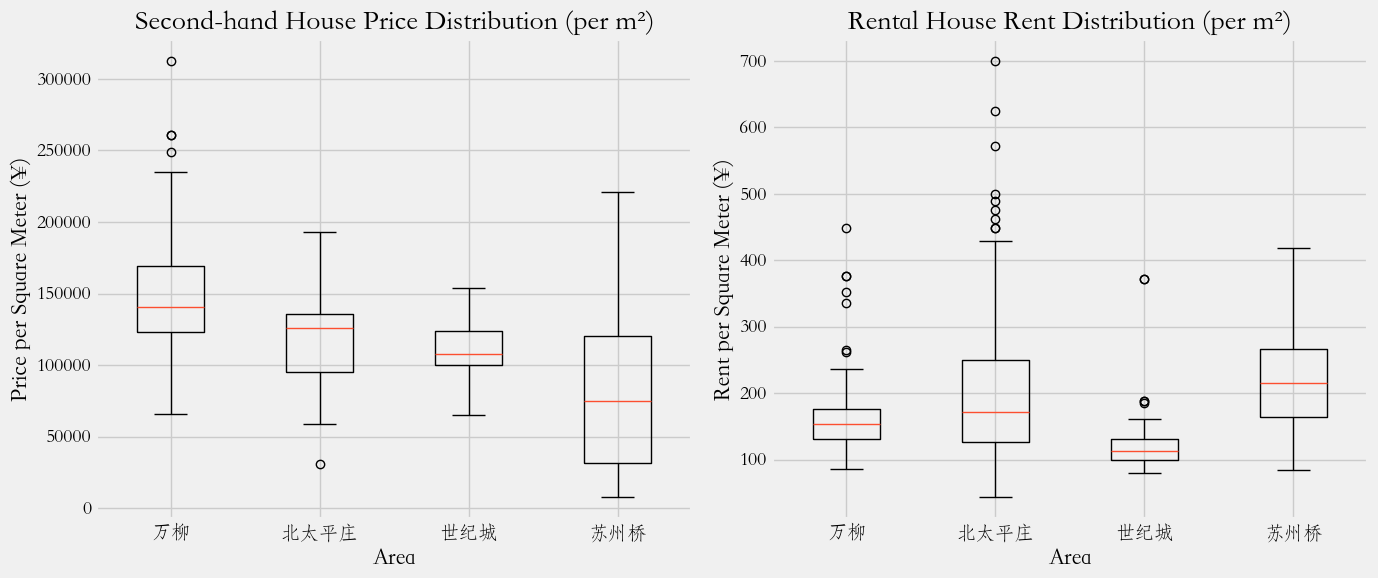

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
matplotlib.rcParams['font.family'] = ['STFangsong']
plt.rcParams['axes.unicode_minus'] = False 

# 分析数据
df_rent = df[df['type'] == '租房'].copy()  # 租房数据
df_esf = df[df['type'] == '二手房'].copy()  # 二手房数据
area_list = ["万柳", "北太平庄", "世纪城", "苏州桥"]

# 清理
df_esf["total_price"] = df_esf["total_price"].replace({'万': ''}, regex=True).astype(float) * 10000
df_esf["area_sqm"] = df_esf["area_sqm"].replace({'㎡': ''}, regex=True).astype(float)
df_esf["unit_price"] = df_esf["unit_price"].replace({'元/㎡': ''}, regex=True).astype(float)
df_rent["area_sqm"] = df_rent["area_sqm"].replace({'㎡': ''}, regex=True).astype(float)
df_rent["month_price"] = df_rent["month_price"].replace({'元/月': ''}, regex=True).astype(float)

# 计算每平方米的价格和租金（单位: 元/㎡）
df_esf["price_per_m2"] = df_esf["unit_price"]  # 二手房每平方米价格
df_rent["rent_per_m2"] = df_rent["month_price"] / df_rent["area_sqm"]  # 租房每平方米租金

# 1) 计算每个区域的描述性统计信息
# 按区域计算二手房的描述性统计
df_esf_area = df_esf[df_esf['area'].isin(area_list)].groupby('area')['price_per_m2'].describe()

# 按区域计算租房的描述性统计
df_rent_area = df_rent[df_rent['area'].isin(area_list)].groupby('area')['rent_per_m2'].describe()

# 打印每个区域的统计信息
print("Second-hand house price per square meter statistics:")
print(df_esf_area)

print("\nRental house rent per square meter statistics:")
print(df_rent_area)

# 设置图表风格
plt.style.use('fivethirtyeight')

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 绘制二手房每平方米价格的箱线图
axes[0].boxplot([df_esf[df_esf['area'] == area]['price_per_m2'] for area in area_list])
axes[0].set_title("Second-hand House Price Distribution (per m²)")
axes[0].set_xlabel("Area")
axes[0].set_ylabel("Price per Square Meter (¥)")
axes[0].set_xticklabels(area_list)

# 绘制租房每平方米租金的箱线图
axes[1].boxplot([df_rent[df_rent['area'] == area]['rent_per_m2'] for area in area_list])
axes[1].set_title("Rental House Rent Distribution (per m²)")
axes[1].set_xlabel("Area")
axes[1].set_ylabel("Rent per Square Meter (¥)")
axes[1].set_xticklabels(area_list)

# 调整布局
plt.tight_layout()
plt.show()



区域 万柳 二手房异常值：
3     249265.0
43    312685.0
68    261054.0
82    261054.0
Name: price_per_m2, dtype: float64

区域 万柳 租房异常值：
618    352.112676
622    335.570470
631    448.916409
642    261.780105
660    264.550265
688    375.586854
693    375.586854
Name: rent_per_m2, dtype: float64

区域 北太平庄 二手房异常值：
327    30777.0
Name: price_per_m2, dtype: float64

区域 北太平庄 租房异常值：
991     500.000000
1002    700.000000
1044    476.190476
1110    448.916409
1120    448.916409
1173    625.000000
1176    488.888889
1183    571.428571
1191    461.538462
Name: rent_per_m2, dtype: float64

区域 世纪城 租房异常值：
706    188.284519
708    372.340426
751    372.340426
763    185.810811
773    188.284519
Name: rent_per_m2, dtype: float64

价格与租金比率（中位数）：
area
万柳      920.416000
世纪城     952.521083
北太平庄    729.821885
苏州桥     348.529412
dtype: float64


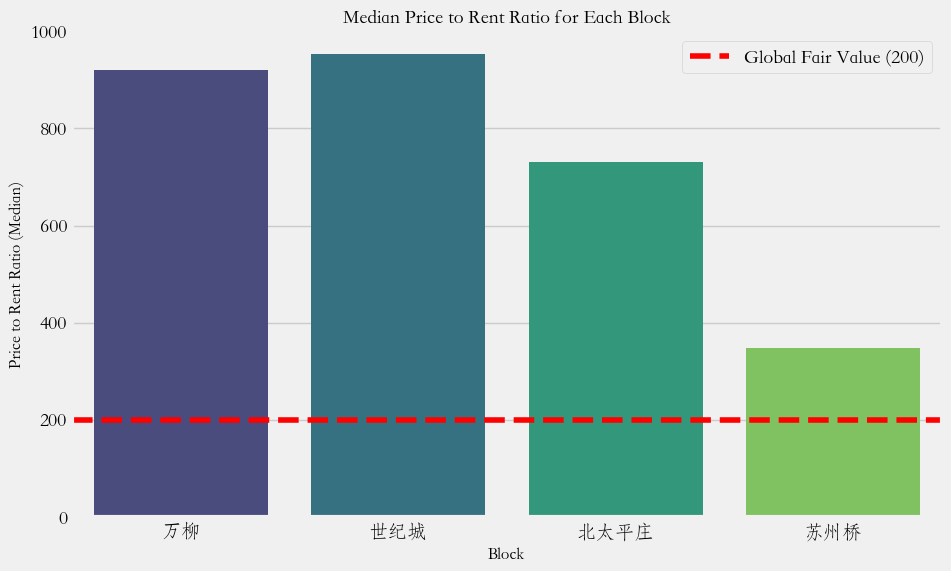

In [21]:

# 2) 异常值检测 - 使用 IQR 方法
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)]

# 打印每个区域的异常值
for area in area_list:
    # 二手房异常值
    esf_outliers = detect_outliers(df_esf[df_esf['area'] == area]['price_per_m2'])
    if len(esf_outliers) > 0:
        print(f"\n区域 {area} 二手房异常值：")
        print(esf_outliers)

    # 租房异常值
    rent_outliers = detect_outliers(df_rent[df_rent['area'] == area]['rent_per_m2'])
    if len(rent_outliers) > 0:
        print(f"\n区域 {area} 租房异常值：")
        print(rent_outliers)

# 3) 计算价格/租金比率
median_price_per_m2 = df_esf[df_esf['area'].isin(area_list)].groupby('area')['price_per_m2'].median()
median_rent_per_m2 = df_rent[df_rent['area'].isin(area_list)].groupby('area')['rent_per_m2'].median()

# 计算价格/租金比率 (price_to_rent_ratio)
price_to_rent_ratio = median_price_per_m2 / median_rent_per_m2

# 打印价格/租金比率
print("\n价格与租金比率（中位数）：")
print(price_to_rent_ratio)

# 4) 绘制每个区域的价格/租金比率的条形图
# 计算的价格/租金比率数据
price_to_rent_ratio = price_to_rent_ratio.reset_index()

# 绘制条形图
plt.figure(figsize=(10, 6))
sns.barplot(x='area', y=0, data=price_to_rent_ratio,hue='area', palette='viridis')

# 添加全局公允值线
plt.axhline(y=200, color='r', linestyle='--', label='Global Fair Value (200)')

# 设置标题和标签
plt.title('Median Price to Rent Ratio for Each Block', fontsize=14)
plt.xlabel('Block', fontsize=12)
plt.ylabel('Price to Rent Ratio (Median)', fontsize=12)
plt.legend()

# 显示图表
plt.show()